In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 
import torch 
from torch import nn

In [2]:
noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


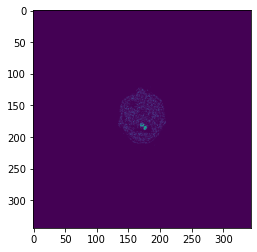

In [3]:
plt.imshow(img_noisyDataSet2[780,:,:])

In [4]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.expand_dims(img_noisyDataSet1, axis=-3)
img_noisyDataSet2 = np.expand_dims(img_noisyDataSet2, axis=-3)
img_groundTruth = np.expand_dims(img_groundTruth, axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [5]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.layer1Down = nn.Sequential (
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
        self.layer2Down = nn.Sequential (
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size= 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer3Down = nn.Sequential (
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer4Down = nn.Sequential (
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer5Down = nn.Sequential (
            torch.nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        self.Pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Expand
        
        self.layer5ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer4Up = nn.Sequential (
            torch.nn.Conv2d(512, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer4ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer3Up = nn.Sequential (
            torch.nn.Conv2d(256, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer3ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer2Up = nn.Sequential (
            torch.nn.Conv2d(128, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer2ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding = 0)
        )
        
        self.layer1Up = nn.Sequential (
            torch.nn.Conv2d(64, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
    
    def forward(self, x):

        # Down
        conv1 = self.layer1Down(x)
        maxPool1 = self.Pooling(conv1)
        
        
        conv2 = self.layer2Down(maxPool1)
        maxPool2 = self.Pooling(conv2)
        
        conv3 = self.layer3Down(maxPool2)
        maxPool3 = self.Pooling(conv3)
        
        conv4 = self.layer4Down(maxPool3)
        maxPool4 = self.Pooling(conv4)
        
        conv5 = self.layer5Down(maxPool4)
        
        # Up
        layerConvTransposed = self.layer5ConvTransposed(conv5)
        layer4UpData = torch.cat((layerConvTransposed,conv4), dim=1)
        convTrans4 = self.layer4Up(layer4UpData)
        
 
        layerConvTransposed = self.layer4ConvTransposed(convTrans4)
        layer3UpData = torch.cat((layerConvTransposed,conv3), dim = 1)
        convTrans3 = self.layer3Up(layer3UpData)
        
        layerConvTransposed = self.layer3ConvTransposed(convTrans3)
        layer2UpData = torch.cat((layerConvTransposed,conv2), dim = 1)
        convTrans2 = self.layer2Up(layer2UpData)
        
        layerConvTransposed = self.layer2ConvTransposed(convTrans2)
        layer1UpData = torch.cat((layerConvTransposed,conv1), dim = 1)
        convTrans1 = self.layer1Up(layer1UpData)
        
        outNet = torch.nn.Conv2d(32,2, kernel_size = 1)(convTrans1)
        return outNet

unet = Unet()
        

In [6]:
if __name__ == '__main__':
    image = torch.rand((4, 1, 256, 256))
    model = Unet()
    out = unet(image)
    

In [7]:
from torchsummary import summary
summary = summary(unet, image)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        320
|    └─BatchNorm2d: 2-2                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-3                         [-1, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 32, 128, 128]        --
├─Sequential: 1-3                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─BatchNorm2d: 2-8                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [-1, 64, 128, 128]        36,928
| 

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [12]:
# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)



In [10]:
# Training U-net Model

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]


In [ ]:
# DataLoader (No funciona)

# np to Tensor
tensor_train_noisyImage = torch.Tensor(train_noisyImage)
tensor_train_groundTruth = torch.Tensor(train_groundTruth)

tensor_test_noisyImage = torch.Tensor(test_noisyImage)
tensor_test_groundTruth = torch.Tensor(test_groundTruth)

tensor_valid_noisyImage = torch.Tensor(valid_noisyImage)
tensor_valid_groundTruth = torch.Tensor(valid_groundTruth)


# dataloader
trainloader = torch.utils.data.DataLoader((tensor_train_noisyImage,tensor_train_groundTruth), batch_size=4,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader((tensor_valid_noisyImage,tensor_valid_groundTruth), batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader((tensor_test_noisyImage,tensor_test_groundTruth), batch_size=4,
                                          shuffle=True, num_workers=2)


for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0

    for i, (inputs, trainGroundTruth) in enumerate(trainloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


In [ ]:
# Tensores

for epoch in range(2):  
    
    running_loss = 0.0

    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.expand_dims(inputs, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.expand_dims(trainGroundTruth, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.025
[1,   101] loss: 1.422
[1,   201] loss: 1.295
[1,   301] loss: 1.505
[1,   401] loss: 1.431
[1,   501] loss: 1.338
